In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyedfread import edf
import pickle
from glob import glob
from os.path import join
%matplotlib inline
import seaborn as sns
from PSPupil import Preprocessing as PS
from PSPupil import dataset as dt
import mne
import scipy
from scipy import stats, signal, interpolate
from scipy.stats import ttest_ind, linregress, f_oneway
from scipy.optimize import curve_fit
import svgutils.transform as sg
from decim.adjuvant import slurm_submit as slu
import matplotlib.colors
import itertools
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as mc


def smaller_than(value):
    logs=np.append(np.logspace(-15, 1, 17), .05)
    sorteds=np.sort(np.append(logs, value))
    index=np.where(sorteds==value)[0]
    return sorteds[index+1][0]

def func_powerlaw(x, m, c, c0):
    return c0 + x**m * c

def permutation_cluster_test(x1, x2):
    f, clusters, pvalues, h0=mne.stats.permutation_cluster_test([x1,x2],
                                                                     threshold=dict(start=0, step=0.2))
    return pvalues

def rgb_to_hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)


def smaller_than(value):
    logs=np.append(np.logspace(-15, 1, 17), .05)
    sorteds=np.sort(np.append(logs, value))
    index=np.where(sorteds==value)[0]
    return sorteds[index+1][0]

def p_annot(p_value):
    if p_value < 0.001:
        text = '<{0}'.format(smaller_than(p_value))
    else:
        text = '%.3f' % p_value

In [2]:
#Plotting parameters
palette = sns.color_palette("Paired")

'''
baseline_color = palette[4]
followup_color = palette[5]
ips_color = palette[0]
control_color = palette[2]
'''

'''
baseline_color = rgb_to_hex(196, 98, 74)
ips_color = rgb_to_hex(123, 118, 19)
control_color = rgb_to_hex(228, 193, 91)
'''

baseline_color = '#F0746E'
follow_color = baseline_color
ips_color = '#7CCBA2'
control_color = '#FCDE9C'

sns.set(style='ticks')
sns.set(style='ticks',font='HelveticaNeue', font_scale=1, rc={
    'axes.labelsize': 6,
    'axes.titlesize': 6,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 6,
    'axes.linewidth': .5,
    'xtick.major.width': .5,
    'ytick.major.width': .5,
        'xtick.minor.width': .5,
    'ytick.minor.width': .5,
    'ytick.major.pad': 0,
    'ytick.minor.pad': 1.0,
    'xtick.major.pad': 1.0,
    'xtick.minor.pad': 1.0,
    'axes.labelpad': 0,
    "xtick.major.size":2,
    "xtick.minor.size":1,
    "ytick.major.size":2,
    "ytick.minor.size":1
})


psize=5
line_width_p = .5
scatter_marker = 16
scatter_alpha=.5

line_width_b = 1.5

lw_power1 = 2
lw_power = 1.5

In [4]:
edition = '/Volumes/psp_data/PSP/Pupil_Preprocessed_2024-06-17/'
slu.mkdir_p(join(edition, 'PowerFrequencies'))
slu.mkdir_p(join(edition, 'Figures'))
slu.mkdir_p(join(edition, 'Figures', 'data'))


In [5]:
pat_data = pd.read_csv('/Users/kenohagena/Documents/Forschung/PSP/data/meta/Patientencharakteristika_Auswertung_Pupillometrie_Marc.csv', 
                       delimiter=';')
pat_data = pat_data.rename(columns={'ID ProPSP': 'subject',
                        'Alter Erstuntersuchung': 'age',
                        'Erkrankungsdauer (Jahre)': 'disease_duration',
                        'PSP Rating Scale': 'psp_rating_scale'}).drop('Patientennummer Pupillometrie', axis=1)

pat_data.disease_duration = pat_data.disease_duration.str.replace(',','.')

psp_baseline_auc = pd.read_hdf(join(edition, 'Figures', 'data', 'psp_baseline_auc.hdf'), key='data')
hip = pd.read_hdf(join(edition, 'Figures', 'data', 'hip.hdf'), key= 'data')
CoV = pd.read_hdf(join(edition, 'Figures', 'data', 'CoV.hdf'), key='data')
fooof = pd.read_hdf(join(edition, 'Figures', 'data', 'fooof_results.hdf'), key= 'data')


FileNotFoundError: File /Volumes/psp_data/PSP/Pupil_Preprocessed_2024-06-17/Figures/data/psp_baseline_auc.hdf does not exist

In [18]:
corr_data= pd.concat([pat_data.set_index(pat_data.subject.astype(int)), 
                      psp_baseline_auc.set_index(psp_baseline_auc.subject.astype(int)),
                     hip.loc[hip.group == 'baseline'].set_index(hip.loc[hip.group == 'baseline'].subject.astype(int)),
                     CoV.loc[(CoV.group == 'PSP')&(CoV.session == 'Baseline')].\
          set_index(CoV.loc[(CoV.group == 'PSP')&(CoV.session == 'Baseline')].subject.astype(int)),
                     fooof.loc[(fooof.group == 'PSP')&(fooof.session == 'Baseline')].\
                      set_index(fooof.loc[(fooof.group == 'PSP')&(fooof.session == 'Baseline')].subject.astype(int))], axis=1)

In [6]:
gait = pd.read_table('/Volumes/psp_data/GaitRite/GAITRite_data_2.tsv', header=[0, 1], index_col=[0, 1, 2], decimal=",")

cols = ['Velocity (cm/sec) normal', 'Step Length (cm) mean normal', 
        'Cadence (Steps/Min) normal', 'Single Support (%GC) mean normal','Step Length SymmetryRatio normal',
       'Velocity (cm/sec) fast', 'Step Length (cm) mean fast', 
        'Cadence (Steps/Min) fast', 'Single Support (%GC) mean fast','Step Length SymmetryRatio fast',
       'Velocity (cm/sec) turn', 'Step Length (cm) mean turn', 
        'Cadence (Steps/Min) turn', 'Single Support (%GC) mean turn','Step Length SymmetryRatio turn']

cols_more = ['Velocity (cm/sec) normal', 'Cadence (Steps/Min) normal', 'Step Length (cm) mean normal', 'Cycle Time (sec) mean normal', 'Single Support (%GC) mean normal', 'Double Support (%GC) mean normal', 'Swing (%GC) mean normal', 'Step Length SymmetryRatio normal',
             'Velocity (cm/sec) fast', 'Cadence (Steps/Min) fast', 'Step Length (cm) mean fast', 'Cycle Time (sec) mean fast', 'Single Support (%GC) mean fast', 'Double Support (%GC) mean fast', 'Swing (%GC) mean fast', 'Step Length SymmetryRatio fast',
             'Velocity (cm/sec) turn', 'Cadence (Steps/Min) turn', 'Step Length (cm) mean turn', 'Cycle Time (sec) mean turn', 'Single Support (%GC) mean turn', 'Double Support (%GC) mean turn', 'Swing (%GC) mean turn', 'Step Length SymmetryRatio turn']
             
       
             

gait_reduced = gait.copy()
gait_reduced.columns = gait_reduced.columns.droplevel(0)

gait_reduced = gait_reduced.reset_index().set_index('level_0').loc[:, cols_more]



c = corr_data.copy()
c.index = c.index.astype(str)
gait_corr = pd.concat([gait_reduced, c], axis=1)#.loc[corr_data.index.astype(str)]



# invalid data, set to NaN

gait_corr.loc['2', 'Step Length SymmetryRatio turn'] = np.nan


# Exclude subjects with no gait data

gait_corr = gait_corr.dropna(axis=1, how='all').loc[~gait_corr.loc[:, 'Velocity (cm/sec) normal'].isnull()]



/Users/kenohagena/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [7]:
# New dataframe with subjects that have gait data (n=15)
# create format with columns for gait parameter + extra column for condition ('fast', 'normal', 'turn')

corr_data["RS"] = corr_data['Subtypen']
corr_data.RS = corr_data.RS.str.contains('PSP-RS')


clinical_df = corr_data.drop('subject', axis=1).reset_index()
clinical_df.subject = clinical_df.subject.astype(str)
clinical_df.disease_duration = clinical_df.disease_duration.astype(float)

cols = []

normal = []
fast = []
turn = []

c = gait_reduced.columns
for column in c:
    d = gait_reduced.loc[:, column]
    column_names = column.split()
    column_names = [i for i in column_names if '(' not in i]
    condition = [column_names[-1]]*len(d)
    category = ''.join(column_names[:-1])
    d = pd.DataFrame({category: d.values, 'condition':condition, 'index':d.index}).set_index(['index', 'condition'])
    if column_names[-1] == 'turn':
        turn.append(d)
    if column_names[-1] == 'normal':
        normal.append(d)
    if column_names[-1] == 'fast':
        fast.append(d)
        


normal = pd.concat(normal, axis=1).reset_index().rename(columns = {'index':'subject'})
cols = normal.columns
normal = normal.merge(clinical_df, on='subject', how='outer')
turn = pd.concat(turn, axis=1).reset_index().rename(columns = {'index':'subject'}).merge(clinical_df, on='subject', how='outer')
fast = pd.concat(fast, axis=1).reset_index().rename(columns = {'index':'subject'}).merge(clinical_df, on='subject', how='outer')

gcp = pd.concat([normal, 
                 fast, 
                 turn], axis=0).reset_index()

gcp = gcp.drop('group', axis=1)
gcp.loc[gcp.RS == True, 'group'] = 'PSP-RS'
gcp.loc[gcp.RS == False, 'group'] = 'vPSP'
gcp.loc[gcp.subject.str[0] == 'I', 'group'] = 'PD'
gcp.loc[gcp.subject.str[0] == 'C', 'group'] = 'HC'


# invalid data, set to NaN

gcp.loc[(gcp.subject == '2')&(gcp.condition == 'turn'), 'StepLengthSymmetryRatio'] = np.nan

## 1.1 Clinical ~ pupil all PSP

disease_duration frequency R2=0.2, p=0.06
psp_rating_scale offset R2=0.22, p=0.04


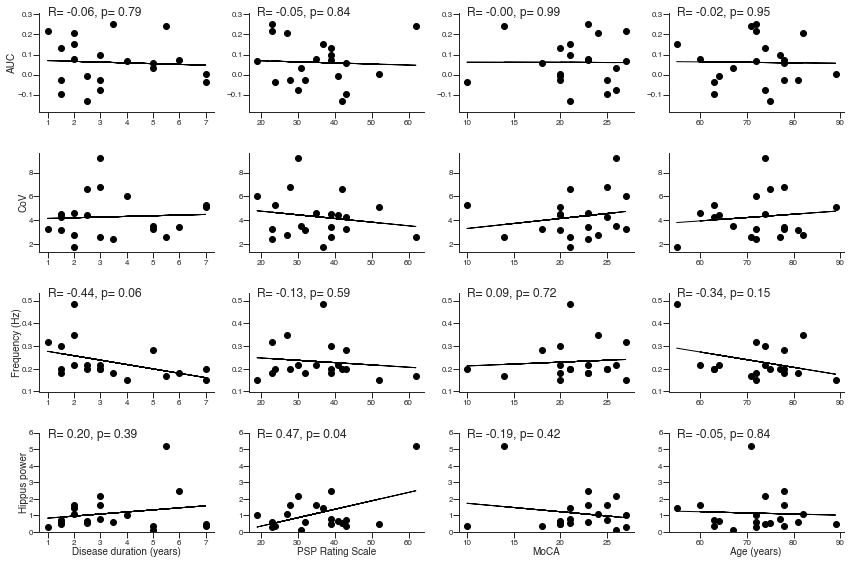

In [9]:
f, ax = plt.subplots(4, 4, figsize=(12, 8))
#f.suptitle('AUC ~ Clinical data')

cols = ['disease_duration', 'psp_rating_scale', 
        'MoCA', 'age']
rows = ['auc', 'CoV', 'frequency', 'offset']

d = {'disease_duration': 'Disease duration (years)', 
     'psp_rating_scale': 'PSP Rating Scale', 
        'MoCA': 'MoCA', 
     'age': 'Age (years)', 
     'auc': 'AUC', 
     'CoV': 'CoV', 
     'frequency': 'Frequency (Hz)', 
     'offset': 'Hippus power'}

for i, col in enumerate(cols):
    for j, row in enumerate(rows):

        x = corr_data.loc[:, col].astype(float).values
        y = corr_data.loc[:, row].astype(float).values
        ax[j, i].scatter(x, y, color='black')
        
        mask = ~np.isnan(x) & ~np.isnan(y)
        slope, intercept, r, p, se = linregress(x[mask], y[mask])
        if p <.1:
            print(col, row, 'R2={0}, p={1}'.format(round(r*r, 2), round(p, 2)))
        ax[j, i].annotate('R= %.2f, p= %.2f' % (r,  p), xy=(x.min(),np.nanmax(y)+ (np.nanmax(y)-np.nanmin(y)) * .1))
        ax[j, i].plot(x, x*slope + intercept, marker='', lw=1, color='black')
        ax[j, i].set(xlabel=d[col],
              ylabel=d[row])
        
        if row == 'offset':
            ax[j, i].set(ylim = (0, 6))


sns.despine()


           
        
for i, a in enumerate(ax):
    for j, axis in enumerate(a):
        if i == 3:
            continue
        else:
            axis.set(xlabel='')
  
        
for i, a in enumerate(ax):
    for j, axis in enumerate(a):
        if j == 0:
            continue
        else:
            axis.set(ylabel='')


f.tight_layout()

f.savefig(join(edition, 'Figures', 'PUPIL_CLINICAL_PSP.png'), dpi=600)

## 1.2 GAIT ~ PUPIL all PSP

auc StepLengthSymmetryRatio fast R2=0.32, p=0.03
CoV Velocity fast R2=0.24, p=0.06
offset StepLengthmean normal R2=0.22, p=0.08
offset SingleSupportmean normal R2=0.2, p=0.09
offset DoubleSupportmean normal R2=0.21, p=0.09
offset DoubleSupportmean turn R2=0.2, p=0.1
offset Swingmean normal R2=0.2, p=0.09
offset StepLengthSymmetryRatio turn R2=0.24, p=0.08


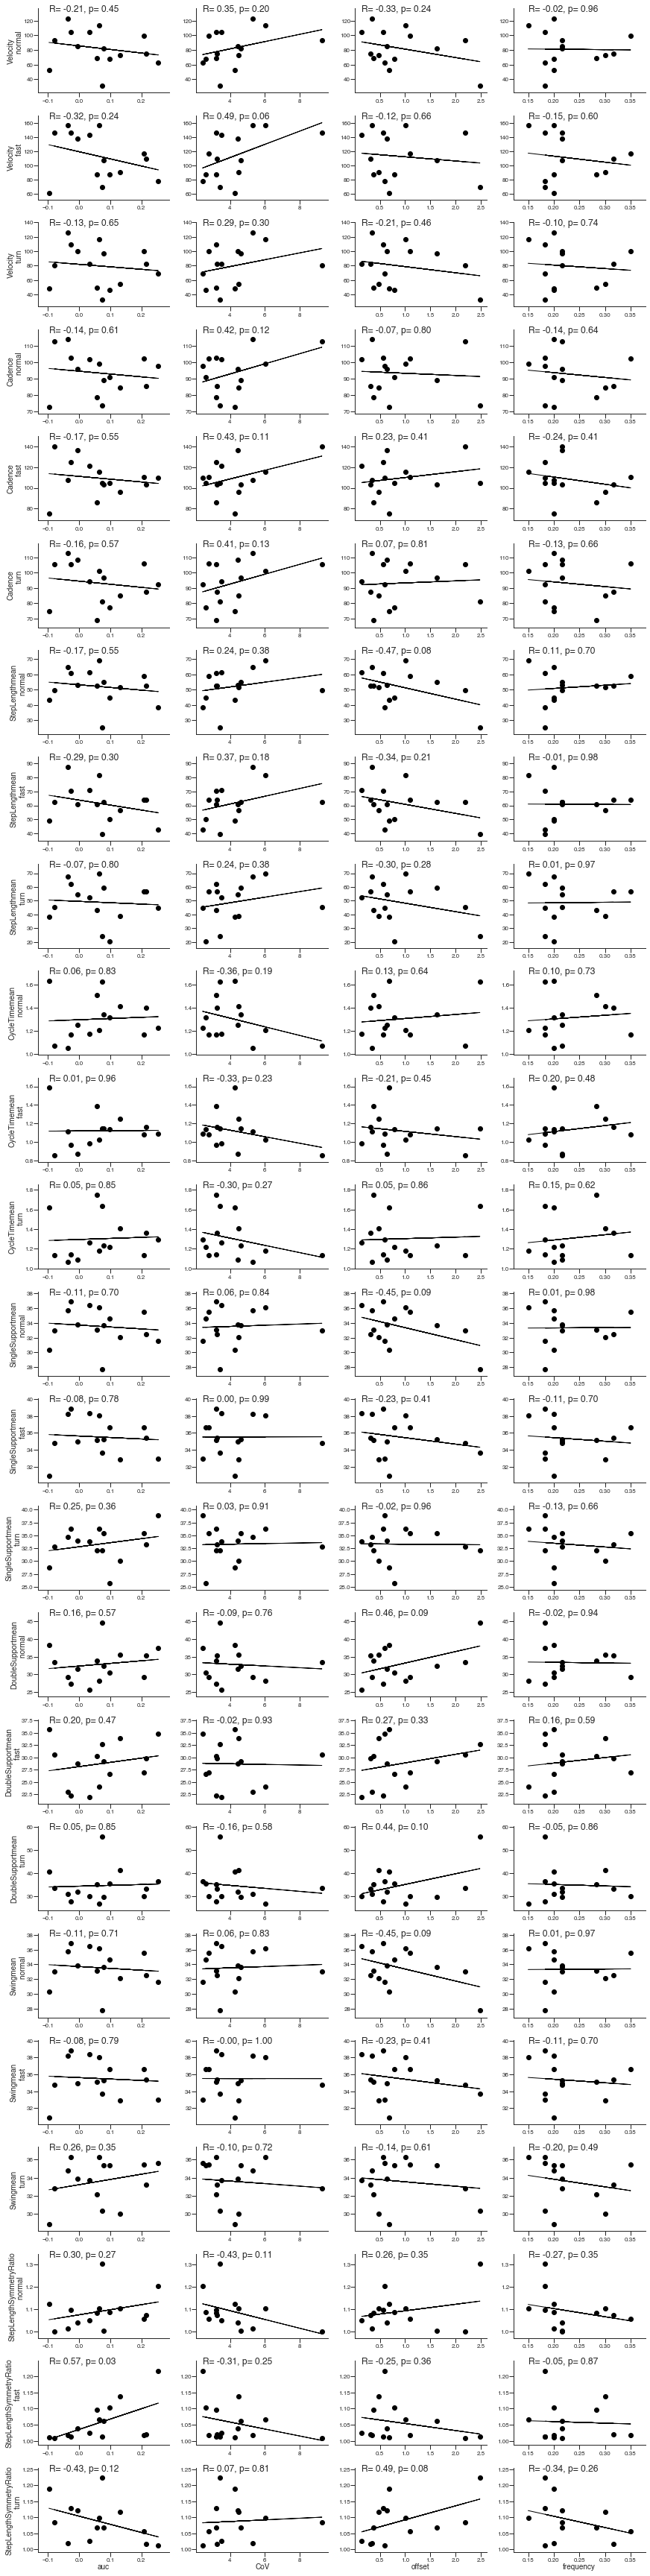

In [63]:
df = gcp.loc[gcp.group.isin(['vPSP', 'PSP-RS'])]

f, ax = plt.subplots(24, 4, figsize=(12, 48))
f.tight_layout()

pupil_parameters = ['auc', 'CoV', 'offset', 'frequency']

gai = ['Velocity', 'Cadence', 'StepLengthmean', 'CycleTimemean', 
        'SingleSupportmean', 'DoubleSupportmean', 'Swingmean', 'StepLengthSymmetryRatio']
cond = ['normal', 'fast', 'turn']

for i, col in enumerate(pupil_parameters):
    for j, ro in enumerate(itertools.product(gai, cond)):

        x = df.loc[df.condition == ro[1], col].astype(float).values
        y = df.loc[df.condition == ro[1], ro[0]].astype(float).values
      
        ax[j, i].scatter(x, y, color='black')
        mask = ~np.isnan(x) & ~np.isnan(y)
        slope, intercept, r, p, se = linregress(x[mask], y[mask])
        if p <.1:
            print(col, ro[0], ro[1], 'R2={0}, p={1}'.format(round(r*r, 2), round(p, 2)))
        ax[j, i].annotate('R= %.2f, p= %.2f' % (r,  p), xy=(np.nanmin(x),np.nanmax(y)+ (np.nanmax(y)-np.nanmin(y)) * .1))
        ax[j, i].plot(x, x*slope + intercept, marker='', lw=1, color='black')
        ax[j, i].set(xlabel=col, ylabel='''{0}
        {1}'''.format(ro[0], ro[1]),
                    ylim=(np.nanmin(y) - (np.nanmax(y)-np.nanmin(y)) * .1, np.nanmax(y) + (np.nanmax(y)-np.nanmin(y)) * .15))
        if ro[0] == 'offset':
            ax[j, i].set(xlim=(0, 3))

for i, a in enumerate(ax):
    for j, axis in enumerate(a):
        if i == 23:
            continue
        else:
            axis.set(xlabel='')
  
        
for i, a in enumerate(ax):
    for j, axis in enumerate(a):
        if j == 0:
            continue
        else:
            axis.set(ylabel='')
            

sns.despine()
#f.savefig(join(edition, 'Figures', 'GAIT_PUPIL_PSP.png'), dpi=600)

## 1.2.1 GAIT ~ PUpil just PSP-RS

auc StepLengthSymmetryRatio fast R2=0.48, p=0.04
auc StepLengthSymmetryRatio turn R2=0.64, p=0.02


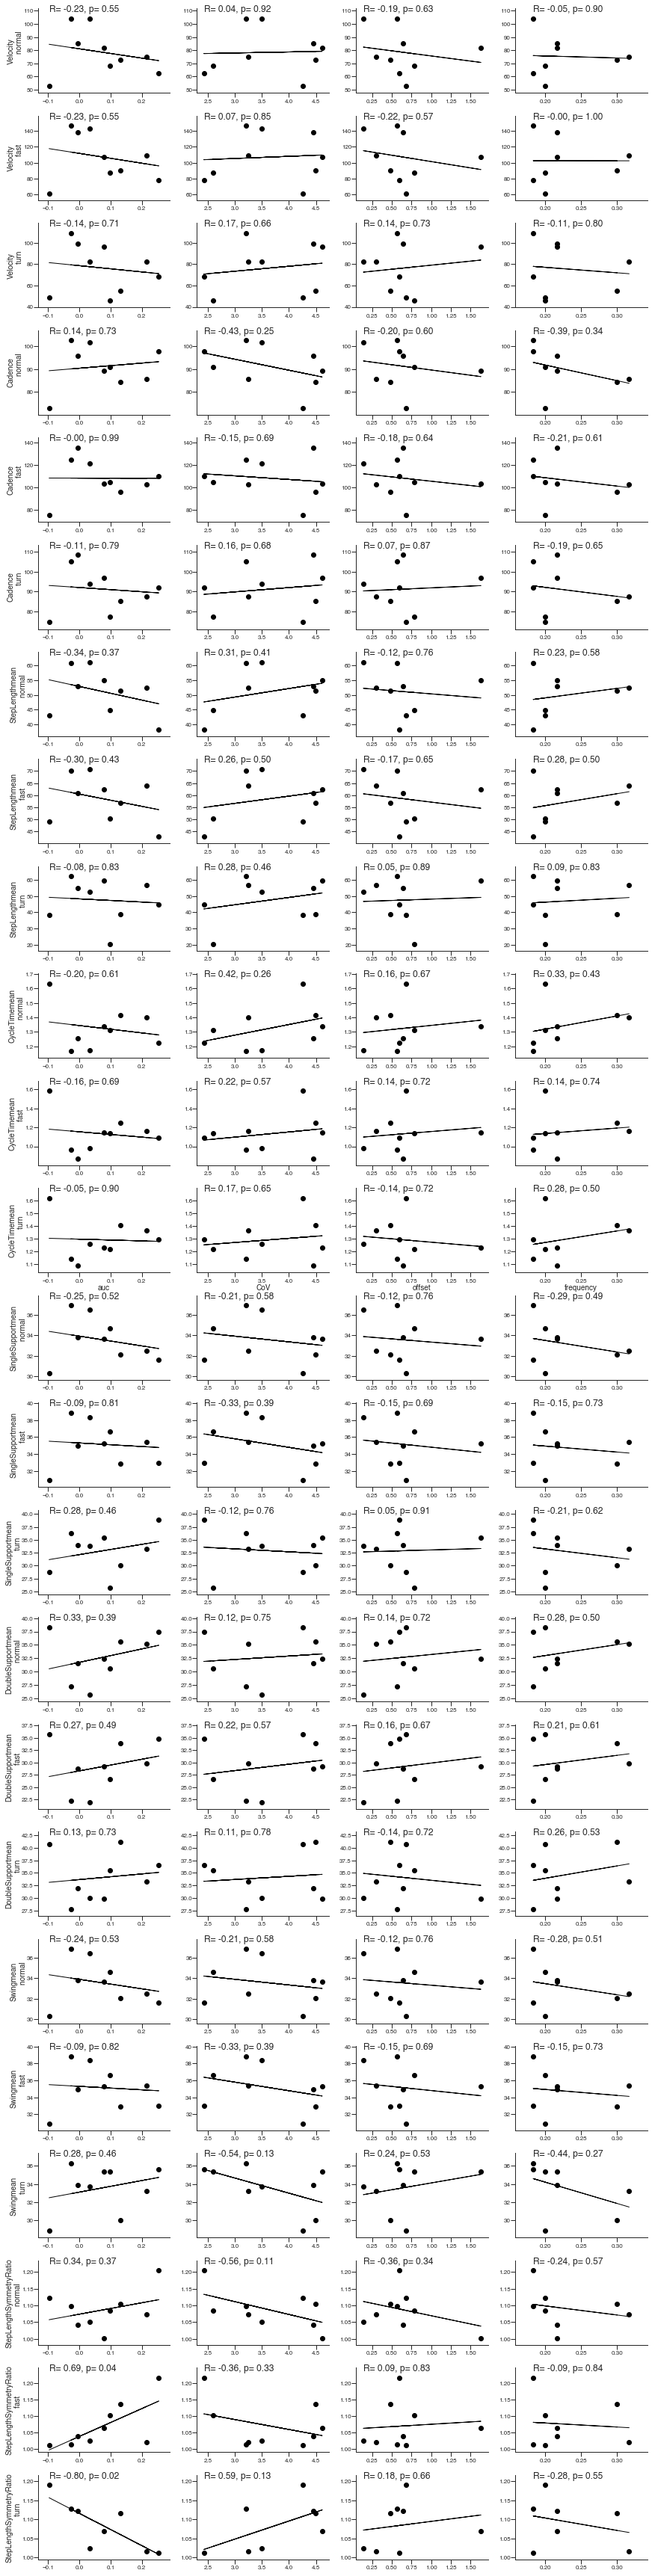

In [11]:
df = gcp.loc[gcp.group == 'PSP-RS']

f, ax = plt.subplots(24, 4, figsize=(12, 48))
f.tight_layout()

pupil_parameters = ['auc', 'CoV', 'offset', 'frequency']

cols = ['Velocity', 'Cadence', 'StepLengthmean', 'CycleTimemean', 
        'SingleSupportmean', 'DoubleSupportmean', 'Swingmean', 'StepLengthSymmetryRatio']
rows = ['normal', 'fast', 'turn']

for i, col in enumerate(pupil_parameters):
    for j, ro in enumerate(itertools.product(gai, cond)):

        x = df.loc[df.condition == ro[1], col].astype(float).values
        y = df.loc[df.condition == ro[1], ro[0]].astype(float).values
      
        ax[j, i].scatter(x, y, color='black')
        mask = ~np.isnan(x) & ~np.isnan(y)
        slope, intercept, r, p, se = linregress(x[mask], y[mask])
        if p <.1:
            print(col, ro[0], ro[1], 'R2={0}, p={1}'.format(round(r*r, 2), round(p, 2)))
        ax[j, i].annotate('R= %.2f, p= %.2f' % (r,  p), xy=(np.nanmin(x),np.nanmax(y)+ (np.nanmax(y)-np.nanmin(y)) * .1))
        ax[j, i].plot(x, x*slope + intercept, marker='', lw=1, color='black')
        ax[j, i].set(xlabel=col, ylabel='''{0}
        {1}'''.format(ro[0], ro[1]),
                    ylim=(np.nanmin(y) - (np.nanmax(y)-np.nanmin(y)) * .1, np.nanmax(y) + (np.nanmax(y)-np.nanmin(y)) * .15))
        if ro[0] == 'offset':
            ax[j, i].set(ylim=(0, 3))

for i, a in enumerate(ax):
    for j, axis in enumerate(a):
        if i == 11:
            continue
        else:
            axis.set(xlabel='')
  
        
for i, a in enumerate(ax):
    for j, axis in enumerate(a):
        if j == 0:
            continue
        else:
            axis.set(ylabel='')
            

sns.despine()
f.savefig(join(edition, 'Figures', 'GAIT_PUPIL_RS.png'), dpi=600)

## 1.2.2 GAIT ~ PUPIL vPSP

NameError: name 'gai' is not defined

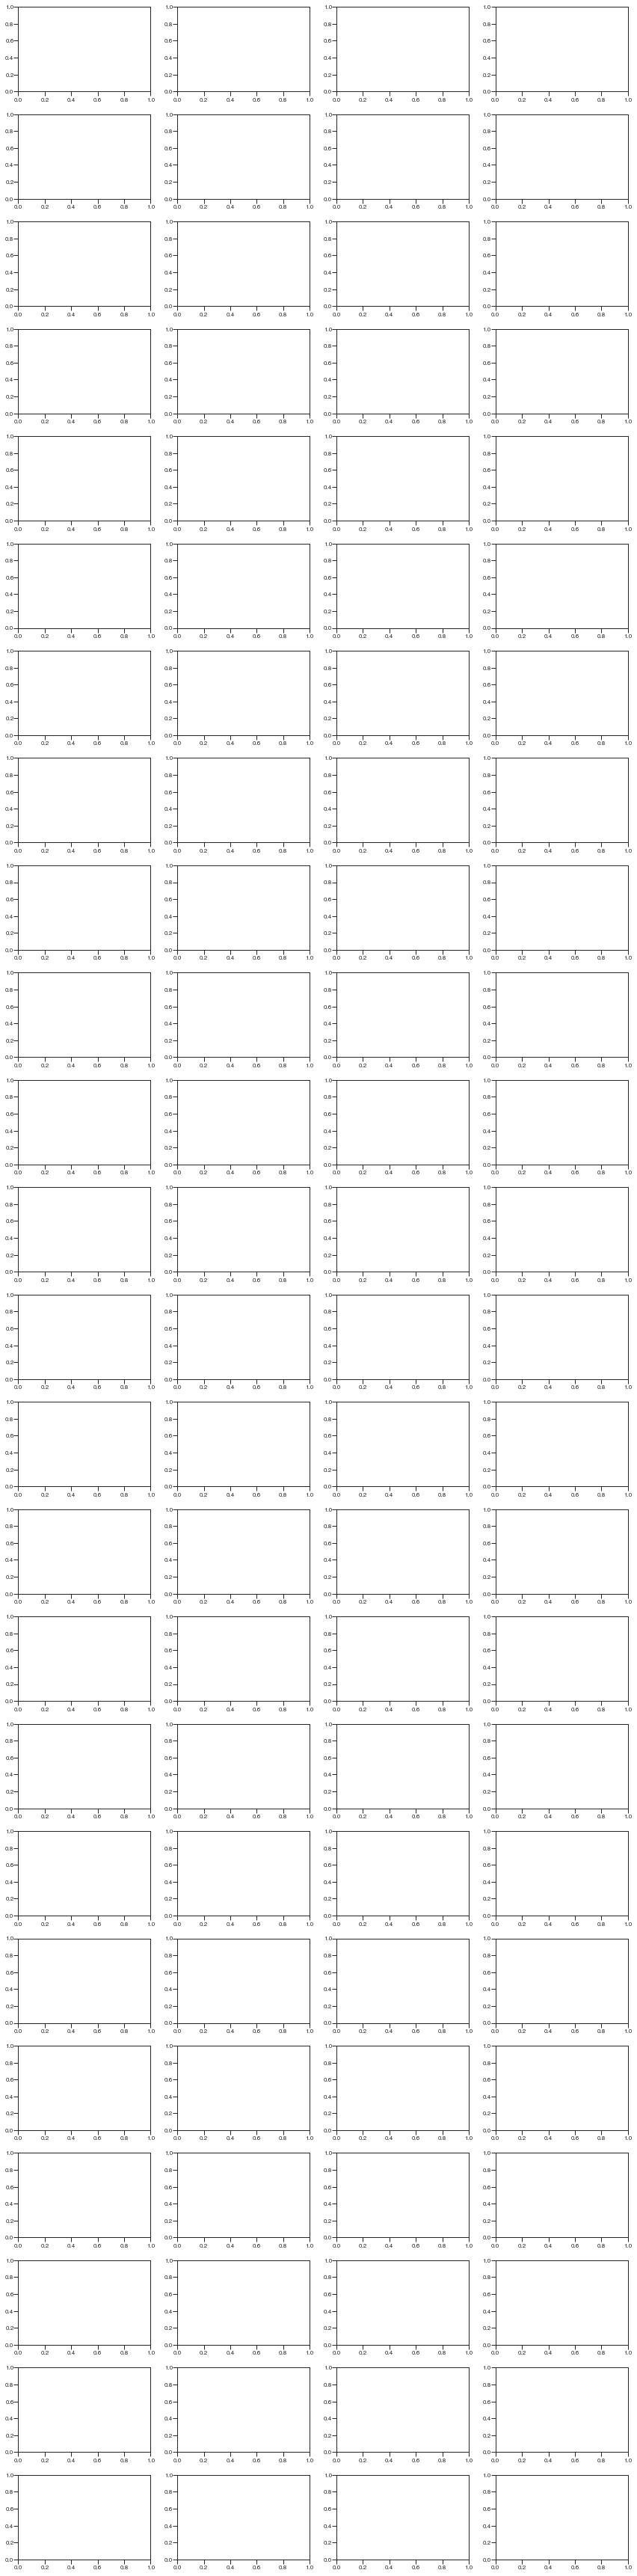

In [62]:
df = gcp.loc[gcp.group == 'vPSP']

f, ax = plt.subplots(24, 4, figsize=(12, 48))
f.tight_layout()

pupil_parameters = ['auc', 'CoV', 'offset', 'frequency']

cols = ['Velocity', 'Cadence', 'StepLengthmean', 'CycleTimemean', 
        'SingleSupportmean', 'DoubleSupportmean', 'Swingmean', 'StepLengthSymmetryRatio']
rows = ['normal', 'fast', 'turn']

for i, col in enumerate(pupil_parameters):
    for j, ro in enumerate(itertools.product(gai, cond)):

        x = df.loc[df.condition == ro[1], col].astype(float).values
        y = df.loc[df.condition == ro[1], ro[0]].astype(float).values
      
        ax[j, i].scatter(x, y, color='black')
        mask = ~np.isnan(x) & ~np.isnan(y)
        slope, intercept, r, p, se = linregress(x[mask], y[mask])
        if p <.1:
            print(col, ro[0], ro[1], 'R2={0}, p={1}'.format(round(r*r, 2), round(p, 2)))
        ax[j, i].annotate('R= %.2f, p= %.2f' % (r,  p), xy=(np.nanmin(x),np.nanmax(y)+ (np.nanmax(y)-np.nanmin(y)) * .1))
        ax[j, i].plot(x, x*slope + intercept, marker='', lw=1, color='black')
        ax[j, i].set(xlabel=col, ylabel='''{0}
        {1}'''.format(ro[0], ro[1]),
                    ylim=(np.nanmin(y) - (np.nanmax(y)-np.nanmin(y)) * .1, np.nanmax(y) + (np.nanmax(y)-np.nanmin(y)) * .15))
        if ro[0] == 'offset':
            ax[j, i].set(ylim=(0, 3))

for i, a in enumerate(ax):
    for j, axis in enumerate(a):
        if i == 11:
            continue
        else:
            axis.set(xlabel='')
  
        
for i, a in enumerate(ax):
    for j, axis in enumerate(a):
        if j == 0:
            continue
        else:
            axis.set(ylabel='')
            

sns.despine()
#f.savefig(join(edition, 'Figures', 'GAIT_PUPIL_vPSP.png'), dpi=600)

## 2.4 Correlations combined - just borderline significant

findfont: Font family ['HelveticaNeue'] not found. Falling back to DejaVu Sans.
findfont: Font family ['HelveticaNeue'] not found. Falling back to DejaVu Sans.


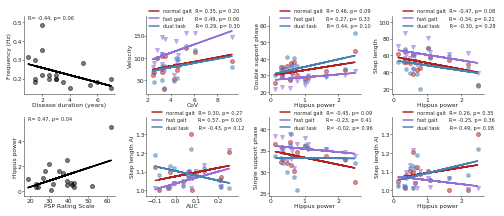

In [8]:
f, ax = plt.subplots(2, 4, figsize=(7, 3))
f.tight_layout()

df = gcp.loc[gcp.group.isin(['vPSP', 'PSP-RS'])]


cols = ['disease_duration', 'psp_rating_scale', 
        'MoCA', 'age']
rows = ['auc', 'CoV', 'frequency', 'offset']

d = {'disease_duration': 'Disease duration (years)', 
     'psp_rating_scale': 'PSP Rating Scale', 
        'MoCA': 'MoCA', 
     'age': 'Age (years)', 
     'auc': 'AUC', 
     'CoV': 'CoV', 
     'frequency': 'Frequency (Hz)', 
     'offset': 'Hippus power',
    'StepLengthSymmetryRatio':"Step length AI",
    'StepLengthmean': 'Step length',
    'DoubleSupportmean': 'Double support phase',
    'SingleSupportmean': 'Single support phase',
     'Velocity': 'Velocity'}

lab = {'fast': 'fast gait',
      'normal': 'normal gait',
      'turn': 'dual task'}


# disease duration ~ frequency
x = corr_data.loc[:, 'disease_duration'].astype(float).values
y = corr_data.loc[:, 'frequency'].astype(float).values
ax[0,0].scatter(x, y, color='black', s=scatter_marker, alpha=.5)
mask = ~np.isnan(x) & ~np.isnan(y)
slope, intercept, r, p, se = linregress(x[mask], y[mask])
ax[0,0].annotate('R= %.2f, p= %.2f' % (r,  p), xy=(x.min(),np.nanmax(y)+ (np.nanmax(y)-np.nanmin(y)) * .1), fontsize=psize)
ax[0,0].plot(x, x*slope + intercept, marker='', lw=line_width_b, color='black')
ax[0,0].set(xlabel=d['disease_duration'],
      ylabel=d['frequency'],
           ylim=(np.nanmin(y) - (np.nanmax(y)-np.nanmin(y)) * .1, np.nanmax(y) + (np.nanmax(y)-np.nanmin(y)) * .15))

# rating scale ~ offset
x = corr_data.loc[:, 'psp_rating_scale'].astype(float).values
y = corr_data.loc[:, 'offset'].astype(float).values
ax[1,0].scatter(x, y, color='black', s=scatter_marker, alpha=.5)
mask = ~np.isnan(x) & ~np.isnan(y)
slope, intercept, r, p, se = linregress(x[mask], y[mask])
ax[1,0].annotate('R= %.2f, p= %.2f' % (r,  p), xy=(x.min(),np.nanmax(y)+ (np.nanmax(y)-np.nanmin(y)) * .1), fontsize=psize)
ax[1,0].plot(x, x*slope + intercept, marker='', lw=line_width_b, color='black')
ax[1,0].set(xlabel=d['psp_rating_scale'],
      ylabel=d['offset'],
           ylim=(np.nanmin(y) - (np.nanmax(y)-np.nanmin(y)) * .1, np.nanmax(y) + (np.nanmax(y)-np.nanmin(y)) * .15))


#GAIT ~ PUPIL
for t in [('CoV', 'Velocity', 0 ,1),
          ('auc', 'StepLengthSymmetryRatio', 1 ,1),
          ('offset', 'DoubleSupportmean', 0 ,2),
          ('offset', 'SingleSupportmean', 1 ,2),
          ('offset', 'StepLengthmean', 0 ,3),
          ('offset', 'StepLengthSymmetryRatio', 1 ,3)
         ]:
    for c, color, di, m in zip(['normal',
                         'fast', 
                         'turn'], ['firebrick', 'mediumpurple', 'steelblue'], ['  ', '       ', '      '], ['o', 'v', 'h']):


        ym = df.loc[:, t[1]].values
        x = df.loc[df.condition == c, t[0]].astype(float).values
        y = df.loc[df.condition == c, t[1]].astype(float).values
        ax[t[2],t[3]].scatter(x, y, color=color, s=scatter_marker, alpha=.5, marker=m)
        mask = ~np.isnan(x) & ~np.isnan(y)
        slope, intercept, r, p, se = linregress(x[mask], y[mask])
        results = 'R= %.2f, p= %.2f' % (r,  p)
        ax[t[2],t[3]].plot(x, x*slope + intercept, marker='', lw=line_width_b, color=color, label = lab[c] + di + results)

    ax[t[2],t[3]].set(xlabel=d[t[0]],
      ylabel=d[t[1]],
           ylim=(np.nanmin(ym) - (np.nanmax(ym)-np.nanmin(ym)) * .1, np.nanmax(ym) + (np.nanmax(ym)-np.nanmin(ym)) * .3))

    ax[t[2],t[3]].legend(bbox_to_anchor=(np.nanmin(df.loc[:, t[0]].values), np.nanmax(ym)+ (np.nanmax(ym)-np.nanmin(ym))*.25),
                   loc='center left', bbox_transform=ax[t[2],t[3]].transData, frameon=False, fontsize = psize)


sns.despine()
f.savefig(join(edition, 'Figures', 'CORRELATIONS_sig.png'), dpi=600)

## 2. Tables

## 2.1 GAIT vPSP vs. PSP-RS vs. HC vs. PD

In [8]:
cols = ['Velocity', 'Cadence', 'StepLengthmean',
       'CycleTimemean', 'SingleSupportmean', 'DoubleSupportmean', 'Swingmean', 'StepLengthSymmetryRatio']

mean = gcp.loc[~gcp.Velocity.isnull()].groupby(['condition', 'group']).mean().loc[:, cols].T
std = gcp.loc[~gcp.Velocity.isnull()].groupby(['condition', 'group']).std().loc[:, cols].T

for condition in ['fast', 'normal', 'turn']:
    for param in mean.index:
        samples = [gcp.loc[(gcp.condition == condition) & (gcp.group == 'PSP-RS'), param].values,
                    gcp.loc[(gcp.condition == condition) & (gcp.group == 'vPSP'), param].values,
                    gcp.loc[(gcp.condition == condition) & (gcp.group == 'PD'), param].values,
                    gcp.loc[(gcp.condition == condition) & (gcp.group == 'HC'), param].values]
        anova = f_oneway(samples[0],samples[1],samples[2],samples[3])
        if anova[1]<0.05:
            print(condition, param)
        mean.loc[param, (condition, 'F')] = anova[0]
        mean.loc[param, (condition, 'p_value')] = anova[1]
        mean.loc[param, (condition, 't_test_RS_vPSP')] = ttest_ind(gcp.loc[(gcp.condition == condition) & (gcp.group == 'PSP-RS'), param].values,
                    gcp.loc[(gcp.condition == condition) & (gcp.group == 'vPSP'), param].values)[1]

fast Velocity
fast Cadence
fast StepLengthmean
fast CycleTimemean
fast SingleSupportmean
fast DoubleSupportmean
fast Swingmean
normal Velocity
normal Cadence
normal StepLengthmean
normal CycleTimemean
normal SingleSupportmean
normal DoubleSupportmean
normal Swingmean
turn Cadence
turn Swingmean


In [9]:
print('mean')
mean.loc[:, ['normal']]

mean


condition                    normal                                    \
group                            HC          PD     PSP-RS       vPSP   
Velocity                 139.033333  100.482222  78.362963  88.155556   
Cadence                  110.918627  109.118889  91.177778  96.672222   
StepLengthmean            75.115667   54.969389  51.139815  53.325278   
CycleTimemean              1.077181    1.115889   1.324074   1.270556   
SingleSupportmean         37.662745   34.421667  33.548148  33.552778   
DoubleSupportmean         24.107843   31.297222  32.685185  33.072222   
Swingmean                 37.658333   34.422222  33.548148  33.558333   
StepLengthSymmetryRatio    1.030606    1.066227   1.086693   1.092884   

condition                                                        
group                            F       p_value t_test_RS_vPSP  
Velocity                 17.728411  1.224120e-07       0.470256  
Cadence                   8.186501  2.012519e-04       0.430302  
StepLengthmean           16.604533  2.600359e-07       0.723713  
CycleTimemean             7.897933  2.628603e-04       0.599531  
SingleSupportmean        10.976646  1.768157e-05       0.997359  
DoubleSupportmean        13.018069  3.480091e-06       0.888090  
Swingmean                10.872575  1.927219e-05       0.994217  
StepLengthSymmetryRatio   2.326662  8.803168e-02       0.887377

In [10]:
print('std')
std

std


condition                     fast                                   \
group                           HC         PD     PSP-RS       vPSP   
Velocity                 29.887494  36.713666  30.248098  37.358544   
Cadence                  17.000806  20.402449  17.707391  17.516360   
StepLengthmean            7.049067  15.145545   9.619830  16.949061   
CycleTimemean             0.101236   0.149811   0.206307   0.171725   
SingleSupportmean         2.597480   3.279900   2.606346   1.849817   
DoubleSupportmean         5.476246   6.684426   5.034047   3.866705   
Swingmean                 2.599265   3.286815   2.615359   1.840401   
StepLengthSymmetryRatio   0.025139   0.081106   0.069469   0.036095   

condition                   normal                                   \
group                           HC         PD     PSP-RS       vPSP   
Velocity                 15.147552  27.288320  17.455932  33.690907   
Cadence                   6.821519  12.942669   9.441928  16.846792   
StepLengthmean            5.756055  12.559471   7.809327  15.651979   
CycleTimemean             0.066951   0.147041   0.147203   0.240589   
SingleSupportmean         1.584490   2.247300   2.196753   3.147246   
DoubleSupportmean         3.111840   4.488527   4.380128   6.114297   
Swingmean                 1.589997   2.250065   2.204532   3.164328   
StepLengthSymmetryRatio   0.022198   0.075385   0.057330   0.109253   

condition                     turn                                   
group                           HC         PD     PSP-RS       vPSP  
Velocity                 22.580367  24.566459  23.226367  37.283399  
Cadence                  12.600593  24.457878  11.483141  17.104511  
StepLengthmean           10.211933  14.713257  13.258536  17.038605  
CycleTimemean             0.127775   0.425226   0.157193   0.295508  
SingleSupportmean         2.935261   7.105752   4.035724   1.815634  
DoubleSupportmean         7.324049  11.478198   4.791790  10.437085  
Swingmean                 2.918627   5.133738   2.573031   2.245481  
StepLengthSymmetryRatio   0.134824   0.132335   0.064461   0.070145

## 2.2 Clinical RS vs. vPSP

In [11]:
# Make a table with clinical characteristics and t-test between RS and vPSP


clinical_RS = clinical_df.loc[:, ['age', 'Geschlecht', 'subject', 'psp_rating_scale', 'MoCA', 'RS', 'disease_duration']].groupby('RS').mean().T
clinical_RS.columns = [clinical_RS.columns, ['mean', 'mean']]

clinical_RS_2 = clinical_df.loc[:, ['age', 'Geschlecht', 'subject', 'psp_rating_scale', 'MoCA', 'RS', 'disease_duration']].groupby('RS').std().T
clinical_RS_2.columns = [clinical_RS_2.columns, ['std', 'std']]

clinical_RS = pd.concat([clinical_RS, clinical_RS_2], axis=1)
clinical_RS['p_value'] = np.nan

for i in ['age', 'psp_rating_scale', 'MoCA', 'disease_duration']:
    clinical_RS.loc[i, ['p_value']]  = ttest_ind(clinical_df.loc[clinical_df.RS == True, i].values, clinical_df.loc[clinical_df.RS != True, i].values)[1]

In [12]:
clinical_RS

RS,False,True,False,True,p_value
,mean,mean,std,std,
age,74.500000,71.285714,6.625708,8.947957,0.441394
psp_rating_scale,30.333333,37.642857,9.114092,10.623683,0.160225
MoCA,21.333333,21.857143,6.377042,3.324898,0.809626
disease_duration,4.500000,2.964286,1.870829,1.748233,0.094519


## Example ANOVA

### one way ANOVA (no repeated measures)

Voraussetzungen:

1. independence
2. Variances equal (not significantly different)
3. Normal verteilt

In [13]:
# 5 subjects do not have GAIT data
print('no gait data for', gcp.loc[gcp.Velocity.isnull()].subject.unique()) # -> exclude these

df = gcp.loc[~gcp.Velocity.isnull()]




no gait data for ['14' '18' '23' '25' '26']


In [14]:
y = df.loc[df.condition == 'normal']['Velocity']
x = df.loc[df.condition == 'normal']['group']

In [15]:
# 1. RUN ANOVA with statsmodel

model = ols('Velocity ~ C(group)', data=df.loc[df.condition == 'normal']).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(group),27470.010887,3.0,17.728411,1.224120e-07
Residual,22209.369380,43.0,NaN,NaN


In [16]:
aov_table['PR(>F)'][0]

1.2241201239586092e-07

In [17]:
# 2. Check assumpotions. 2.1 Check e.g. with shapiros test for normality

stats.shapiro(model.resid)

ShapiroResult(statistic=0.9853790998458862, pvalue=0.8156834244728088)

The test is non-significant, which indicates that the residuals are normally distributed.

In [18]:
# 2.2 check e.g. with Levenes test for homogeneity of variances

stats.levene(df.loc[(df.condition == 'normal')&(df.group == 'PSP-RS')]['Velocity'],
            df.loc[(df.condition == 'normal')&(df.group == 'vPSP')]['Velocity'],
            df.loc[(df.condition == 'normal')&(df.group == 'PD')]['Velocity'],
            df.loc[(df.condition == 'normal')&(df.group == 'HC')]['Velocity'])
    


LeveneResult(statistic=1.783232639016664, pvalue=0.16464264404350443)

The Levene's test of homogeneity of variances is not significant which indicates that the groups have non-statistically significant difference in their varability.

In [19]:
# 3. Run post-hoc (theroretically also t-test works)

comp = mc.MultiComparison(y, x)
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
HC,PD,-38.5511,0.001,-60.0677,-17.0345,True
HC,PSP-RS,-60.6704,0.001,-85.709,-35.6318,True
HC,vPSP,-50.8778,0.001,-79.7203,-22.0353,True
PD,PSP-RS,-22.1193,0.1121,-47.7291,3.4906,False
PD,vPSP,-12.3267,0.659,-41.6665,17.0131,False
PSP-RS,vPSP,9.7926,0.8279,-22.2198,41.8049,False


In [20]:
cols = ['Velocity', 'Cadence', 'StepLengthmean',
       'CycleTimemean', 'SingleSupportmean', 'DoubleSupportmean', 'Swingmean', 'StepLengthSymmetryRatio']

data = gcp.loc[~gcp.StepLengthSymmetryRatio.isnull()]

mean = data.groupby(['condition', 'group']).mean().loc[:, cols].T
std = data.groupby(['condition', 'group']).std().loc[:, cols].T

for condition in ['fast', 'normal', 'turn']:
    for param in mean.index:
        
        
        
        
        
        samples = [data.loc[(data.condition == condition) & (data.group == 'PSP-RS'), param].values,
                    data.loc[(data.condition == condition) & (data.group == 'vPSP'), param].values,
                    data.loc[(data.condition == condition) & (data.group == 'PD'), param].values,
                    data.loc[(data.condition == condition) & (data.group == 'HC'), param].values]
        
        model = ols('{0} ~ C(group)'.format(param), data=data.loc[df.condition == condition]).fit()
        aov_table = sm.stats.anova_lm(model, typ=2)
        F = aov_table['F'][0]
        ANOVA_p = aov_table['PR(>F)'][0]
        levene_p = stats.levene(samples[0], samples[1], samples[2], samples[3])[1]
        shapiro_p = stats.shapiro(model.resid)[1]
        
        comp = mc.MultiComparison(data.loc[data.condition == condition, param].values, data.loc[data.condition == condition, 'group'].values)
        post_hoc_res = comp.tukeyhsd()
        tukey = pd.read_html(post_hoc_res.summary().as_html(), header=0)[0]
              
        
        mean.loc[param, (condition, 'F')] = F
        mean.loc[param, (condition, 'ANOVA_p')] = ANOVA_p
        mean.loc[param, (condition, 'levene_p')] = levene_p
        mean.loc[param, (condition, 'shapiro_p')] = shapiro_p
        
        for combo in itertools.combinations(gcp.group.unique(), 2): 
            
            try:
                mean.loc[param, (condition, 'tukey_{0}_{1}'.format(combo[0], combo[1]))] =\
                tukey.loc[(tukey.group2 == combo[0])&(tukey.group1 == combo[1])]['p-adj'].values[0]
                
                
                
            except IndexError:
                mean.loc[param, (condition, 'tukey_{0}_{1}'.format(combo[0], combo[1]))] =\
                tukey.loc[(tukey.group1 == combo[0])&(tukey.group2 == combo[1])]['p-adj'].values[0]                
            

In [26]:
mean.stack('condition')

group                                   ANOVA_p          F          HC  \
                        condition                                        
Velocity                fast       1.198960e-08  21.449397  204.831373   
                        normal     1.224120e-07  17.728411  139.033333   
                        turn       1.693378e-01   1.760825   98.451961   
Cadence                 fast       1.333206e-04   8.638102  141.773529   
                        normal     2.012519e-04   8.186501  110.918627   
                        turn       6.312941e-02   2.621555  111.592157   
StepLengthmean          fast       1.578044e-06  14.066975   86.745618   
                        normal     2.600359e-07  16.604533   75.115667   
                        turn       6.672036e-01   0.525442   52.004221   
CycleTimemean           fast       9.148125e-05   9.058330    0.850010   
                        normal     2.628603e-04   7.897933    1.077181   
                        turn       2.491020e-01   1.424371    1.096000   
SingleSupportmean       fast       3.137453e-05  10.291305   40.822059   
                        normal     1.768157e-05  10.976646   37.662745   
                        turn       3.017510e-01   1.255964   36.329412   
DoubleSupportmean       fast       5.376220e-06  12.457078   16.958333   
                        normal     3.480091e-06  13.018069   24.107843   
                        turn       2.003933e-01   1.614294   32.030392   
Swingmean               fast       3.239931e-05  10.253412   40.816667   
                        normal     1.927219e-05  10.872575   37.658333   
                        turn       4.704884e-02   2.880861   36.328431   
StepLengthSymmetryRatio fast       2.660080e-01   1.365713    1.028560   
                        normal     8.803168e-02   2.326662    1.030606   
                        turn       7.028493e-01   0.472831    1.138215   

group                                      PD      PSP-RS  levene_p  \
                        condition                                     
Velocity                fast       144.492222  106.992593  0.679060   
                        normal     100.482222   78.362963  0.164643   
                        turn        79.998889   80.241667  0.301196   
Cadence                 fast       132.045556  108.351852  0.926481   
                        normal     109.118889   91.177778  0.106821   
                        turn       107.202222   92.983333  0.373830   
StepLengthmean          fast        66.130111   58.540000  0.091951   
                        normal      54.969389   51.139815  0.025988   
                        turn        46.613000   50.874792  0.342391   
CycleTimemean           fast         0.926444    1.132593  0.575137   
                        normal       1.115889    1.324074  0.062511   
                        turn         1.215111    1.300417  0.565672   
SingleSupportmean       fast        37.395556   35.137037  0.774250   
                        normal      34.421667   33.548148  0.348649   
                        turn        33.320000   33.766667  0.278411   
DoubleSupportmean       fast        25.511667   29.219444  0.810660   
                        normal      31.297222   32.685185  0.390695   
                        turn        38.956111   33.912500  0.578748   
Swingmean               fast        37.397222   35.136111  0.764805   
                        normal      34.422222   33.548148  0.353522   
                        turn        32.672222   33.368750  0.235110   
StepLengthSymmetryRatio fast         1.061049    1.070009  0.321867   
                        normal       1.066227    1.086693  0.060525   
                        turn         1.114043    1.084725  0.629586   

group                                 shapiro_p  tukey_HC_PD  tukey_PSP-RS_HC  \
                        condition                                               
Velocity                fast       5.174700e-02       0.0010      

In [37]:
stacked = mean.stack('condition')


In [38]:
def smaller_than(value):
    logs=np.append(np.logspace(-15, 1, 17), .05)
    sorteds=np.sort(np.append(logs, value))
    index=np.where(sorteds==value)[0]
    return sorteds[index+1][0]

def p_annot(p_value, dec):
    10**-3
    if p_value < 10**-dec:
        text = '<{0}'.format(smaller_than(p_value))
    else:
        text = '{}'.format(np.round(p_value, dec))
    return text

stacked = mean.stack('condition')

for i in std.stack('condition').index:
    for group in ['HC', 'vPSP', 'PSP-RS', 'PD']:
        if i[0] == 'StepLengthSymmetryRatio':
            
            stacked.loc[i, group] = '{0} ± {1}'.format(np.round(stacked.loc[i, group], decimals=2), np.round(std.stack('condition').loc[i, group], decimals=2))
        else:
            stacked.loc[i, group] = '{0} ± {1}'.format(np.round(stacked.loc[i, group], decimals=1), np.round(std.stack('condition').loc[i, group], decimals=1))            
    stacked.loc[i, 'F'] = p_annot(stacked.loc[i, 'F'], dec=2) 
    for c in ['ANOVA_p', 'levene_p', 'shapiro_p', 'tukey_PSP-RS_vPSP', 'tukey_PSP-RS_PD', 'tukey_vPSP_PD', 'tukey_PSP-RS_HC', 'tukey_vPSP_HC']:        
        stacked.loc[i, c] = p_annot(stacked.loc[i, c], dec=3) 






In [39]:
cols = ['PSP-RS', 'vPSP', 'PD', 'HC', 'F', 'ANOVA_p', 'levene_p', 'shapiro_p', 'tukey_PSP-RS_vPSP', 'tukey_PSP-RS_PD', 'tukey_vPSP_PD', 'tukey_PSP-RS_HC', 'tukey_vPSP_HC']
stacked.loc[:, cols].astype(str).to_csv(join(edition, 'Figures', 'data', 'GAIT_table.csv'), sep = ',')

In [40]:
stacked['tukey_PSP-RS_vPSP'].values

stacked= stacked.loc[:, cols]

In [30]:
d = stacked.reset_index().T.reset_index().T

from docx import Document
doc = Document()
t = doc.add_table(rows=d.shape[0], cols=d.shape[1])

for i in range(d.shape[0]):
    for j in range(d.shape[1]):
        cell = d.iat[i, j]
        t.cell(i, j).text = str(cell)

doc.save(join(edition, 'Figures', 'data', 'Gait_table.docx'))

In [41]:
stacked

group                                    PSP-RS          vPSP            PD  \
                        condition                                             
Velocity                fast       107.0 ± 30.2  122.1 ± 37.4  144.5 ± 36.7   
                        normal      78.4 ± 17.5   88.2 ± 33.7  100.5 ± 27.3   
                        turn        80.2 ± 21.6   84.1 ± 37.3   80.0 ± 24.6   
Cadence                 fast       108.4 ± 17.7  110.7 ± 17.5  132.0 ± 20.4   
                        normal       91.2 ± 9.4   96.7 ± 16.8  109.1 ± 12.9   
                        turn        93.0 ± 10.9   95.8 ± 17.1  107.2 ± 24.5   
StepLengthmean          fast         58.5 ± 9.6   65.9 ± 16.9   66.1 ± 15.1   
                        normal       51.1 ± 7.8   53.3 ± 15.7   55.0 ± 12.6   
                        turn         50.9 ± 9.2   51.1 ± 17.0   46.6 ± 14.7   
CycleTimemean           fast          1.1 ± 0.2     1.1 ± 0.2     0.9 ± 0.1   
                        normal        1.3 ± 0.1     1.3 ± 0.2     1.1 ± 0.1   
                        turn          1.3 ± 0.2     1.3 ± 0.3     1.2 ± 0.4   
SingleSupportmean       fast         35.1 ± 2.6    36.1 ± 1.8    37.4 ± 3.3   
                        normal       33.5 ± 2.2    33.6 ± 3.1    34.4 ± 2.2   
                        turn         33.8 ± 3.2    33.9 ± 1.8    33.3 ± 7.1   
DoubleSupportmean       fast         29.2 ± 5.0    28.0 ± 3.9    25.5 ± 6.7   
                        normal       32.7 ± 4.4    33.1 ± 6.1    31.3 ± 4.5   
                        turn         33.9 ± 5.1   35.5 ± 10.4   39.0 ± 11.5   
Swingmean               fast         35.1 ± 2.6    36.1 ± 1.8    37.4 ± 3.3   
                        normal       33.5 ± 2.2    33.6 ± 3.2    34.4 ± 2.3   
                        turn         33.4 ± 2.7    33.6 ± 2.2    32.7 ± 5.1   
StepLengthSymmetryRatio fast        1.07 ± 0.07   1.04 ± 0.04   1.06 ± 0.08   
                        normal      1.09 ± 0.06   1.09 ± 0.11   1.07 ± 0.08   
                        turn        1.08 ± 0.06   1.09 ± 0.07   1.11 ± 0.13   

group                                        HC      F  ANOVA_p levene_p  \
                        condition                                          
Velocity                fast       204.8 ± 29.9  21.45   <1e-07    0.679   
                        normal     139.0 ± 15.1  17.73   <1e-06    0.165   
                        turn        98.5 ± 22.6   1.76    0.169    0.301   
Cadence                 fast       141.8 ± 17.0   8.64   <0.001    0.926   
                        normal      110.9 ± 6.8   8.19   <0.001    0.107   
                        turn       111.6 ± 12.6   2.62    0.063    0.374   
StepLengthmean          fast         86.7 ± 7.0  14.07   <1e-05    0.092   
                        normal       75.1 ± 5.8   16.6   <1e-06    0.026   
                        turn        52.0 ± 10.2   0.53    0.667    0.342   
CycleTimemean           fast          0.9 ± 0.1   9.06  <0.0001    0.575   
                        normal        1.1 ± 0.1    7.9   <0.001    0.063   
                        turn          1.1 ± 0.1   1.42    0.249    0.566   
SingleSupportmean       fast         40.8 ± 2.6  10.29  <0.0001    0.774   
                        normal       37.7 ± 1.6  10.98  <0.0001    0.349   
                        turn         36.3 ± 2.9   1.26    0.302    0.278   
DoubleSupportmean       fast         17.0 ± 5.5  12.46   <1e-05    0.811   
                        normal       24.1 ± 3.1  13.02   <1e-05    0.391   
                        turn         32.0 ± 7.3   1.61      0.2    0.579   
Swingmean               fast         40.8 ± 2.6  10.25  <0.0001    0.765   
                        normal       37.7 ± 1.6  10.87  <0.0001    0.354   
                        turn         36.3 ± 2.9   2.88    0.047    0.235   
StepLengthSymmetryRatio fast        1.03 ± 0.03   1.37    0.266    0.322   
                        normal      1.03 ± 0.02   2.33    0.088    0.061   
                        turn        1.14 ± 0.

In [10]:
gcp.loc[gcp.Velocity.isnull()]

,index,subject,condition,Velocity,Cadence,StepLengthmean,CycleTimemean,SingleSupportmean,DoubleSupportmean,Swingmean,...,auc,frequency,offset,hippus_power,session,mean,std,CoV,RS,group
47,47,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.244441,0.166667,5.192533,NaN,Baseline,41.802313,1.084513,2.599643,True,PSP-RS
48,48,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001319,0.150000,0.448305,NaN,Baseline,49.175055,2.530088,5.146957,True,PSP-RS
49,49,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.131842,0.200000,0.533892,NaN,Baseline,62.472978,4.119435,6.622725,True,PSP-RS
50,50,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.024889,0.200000,1.598439,NaN,Baseline,90.312601,6.066538,6.757917,True,PSP-RS
51,51,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.151573,0.483333,1.459512,NaN,Baseline,71.475120,1.247727,1.745872,True,PSP-RS
99,47,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.244441,0.166667,5.192533,NaN,Baseline,41.802313,1.084513,2.599643,True,PSP-RS
100,48,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001319,0.150000,0.448305,NaN,Baseline,49.175055,2.530088,5.146957,True,PSP-RS
101,49,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.131842,0.200000,0.533892,NaN,Baseline,62.472978,4.119435,6.622725,True,PSP-RS
102,50,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.024889,0.200000,1.598439,NaN,Baseline,90.312601,6.066538,6.757917,True,PSP-RS
103,51,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.151573,0.483333,1.459512,NaN,Baseline,71.475120,1.247727,1.745872,True,PSP-RS


In [16]:
pat_data.disease_duration = pat_data.disease_duration.astype(float)
pat_data.median()

subject             15.0
age                 73.0
disease_duration     3.0
psp_rating_scale    36.0
MoCA                22.0
dtype: float64

In [19]:
pat_data.quantile(0.25)

subject              8.50
age                 66.25
disease_duration     2.00
psp_rating_scale    27.75
MoCA                20.00
Name: 0.25, dtype: float64

In [20]:
pat_data.quantile(0.75)

subject             21.25
age                 78.00
disease_duration     5.00
psp_rating_scale    41.25
MoCA                25.00
Name: 0.75, dtype: float64

In [21]:
pat_data

,subject,Geschlecht,age,disease_duration,Subtypen,psp_rating_scale,MoCA
0,1,m,63,1.5,PSP-RS,43,25
1,2,m,77,3.0,PSP-RS,39,21
2,3,m,82,2.0,PSP-P/F,27,24
3,6,w,78,6.0,PSP-P,39,23
4,7,m,81,1.5,PSP-RS,32,20
5,9,m,63,7.0,PSP-P/F,24,10
6,10,m,60,2.0,PSP-RS,35,23
7,12,w,72,1.0,PSP-RS,23,27
8,13,m,72,4.0,PSP-P,19,27
9,14,w,71,5.5,PSP-RS,62,14
